# Project 5: Forecasting Load Data and More  
Team: AWESOME  
Members: Stacey, Prasoon, Michael

In [1]:
# imports

# standard
from pandas import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# statsmodel
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tools.eval_measures import bic

# settings
import warnings
warnings.filterwarnings('ignore')

# global matplotlib settings

plt.rcParams['axes.grid'] = False
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#611BB8", "red", "green"]) 

# This will allow us to avoid a FutureWarning when plotting.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.options.display.max_rows=500

/home/karma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


---
## Data

In [2]:
# Directory Paths
load_data_dir = "../data/load_data"
weather_data_dir = "../data/weather_data"

### Load Data

In [3]:
def combine_nyiso_data(data_dir_path):
    """
    param(s):
        data_dir_path: (string) directory path to folder containing csv files
    returns:
        dataframe with combined csv data
    """
    dfs = []
    files = os.listdir(data_dir_path)
    for file in files:
        file_path = data_dir_path + file
        _df = pd.read_csv(file_path)
        dfs.append(_df)
    NYISO_combined_df = pd.concat(dfs)
    return NYISO_combined_df

In [4]:
load_2018=pd.read_csv('../data/load_data/OASIS_LOAD_2018.csv')
load_2019=pd.read_csv('../data/load_data/OASIS_LOAD_2019.csv')

load_list=[load_2018,load_2019]
combined_load=pd.concat(load_list)

combined_load.head(3)

RTD End Time Stamp Zone Name  Zone PTID  RTD Actual Load
0  2018/01/01 00:05:00    N.Y.C.      61761           6200.1
1  2018/01/01 00:10:00    N.Y.C.      61761           6134.1
2  2018/01/01 00:15:00    N.Y.C.      61761           6134.0

In [5]:
combined_load.shape

(213022, 4)

In [6]:
combined_load['RTD End Time Stamp']=pd.DatetimeIndex(combined_load['RTD End Time Stamp'])
combined_load=combined_load.set_index('RTD End Time Stamp')
combined_load.head(3)

Zone Name  Zone PTID  RTD Actual Load
RTD End Time Stamp                                       
2018-01-01 00:05:00    N.Y.C.      61761           6200.1
2018-01-01 00:10:00    N.Y.C.      61761           6134.1
2018-01-01 00:15:00    N.Y.C.      61761           6134.0

### Down sampling the Load Data

> Downsampling the comined_load data to match to the weather data for nyc

In [7]:
resample = combined_load.resample('H', label='right', closed='right').mean()
resample.head(3)

Zone PTID  RTD Actual Load
RTD End Time Stamp                             
2018-01-01 01:00:00      61761      6085.233333
2018-01-01 02:00:00      61761      5910.608333
2018-01-01 03:00:00      61761      5749.016667

In [8]:
combined_load.isnull().sum()

Zone Name           0
Zone PTID           0
RTD Actual Load    10
dtype: int64

> impute missing values with the mean of the Load data

In [9]:
combined_load.fillna(combined_load['RTD Actual Load'].mean(),inplace=True);

In [10]:
combined_load.isnull().sum()

Zone Name          0
Zone PTID          0
RTD Actual Load    0
dtype: int64

> Sanity Check

In [11]:
combined_load['RTD Actual Load'].describe()

count    213022.000000
mean       6021.395738
std        1268.992293
min        3752.800000
25%        5108.200000
50%        5906.900000
75%        6602.675000
max       11110.300000
Name: RTD Actual Load, dtype: float64

### Weather Data

In [12]:
weather_df = pd.read_csv('../data/weather_data/nyc_weather.csv')
weather_df.head(3)

date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  2018-01-01 00:00:00        -7       -12           0.0      8.7        2   
1  2018-01-01 01:00:00        -7       -12           0.0      8.7        2   
2  2018-01-01 02:00:00        -7       -12           0.0      8.7        2   

   moon_illumination  moonrise   moonset   sunrise  ... WindGustKmph  \
0                 97  05:34 PM  07:33 AM  08:20 AM  ...           31   
1                 97  05:34 PM  07:33 AM  08:20 AM  ...           31   
2                 97  05:34 PM  07:33 AM  08:20 AM  ...           31   

   cloudcover  humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
0           9        70       0.0      1028    -11          10            324   
1          10        70       0.0      1028    -11          10            324   
2          11        69       0.0      1028    -11          10            323   

   windspeedKmph  location  
0             26       nyc  
1             27       nyc  
2             27       nyc  

[3 rows x 25 columns]

In [13]:
weather_df.shape

(17520, 25)

In [14]:
weather_df['date_time']=pd.DatetimeIndex(weather_df['date_time'])
weather_df=weather_df.set_index('date_time')

### Combine Load and Weather Data

In [15]:
load_weather_combined=pd.merge(resample,weather_df,left_index=True,right_index=True)

In [16]:
load_weather_combined.head(3)

Zone PTID  RTD Actual Load  maxtempC  mintempC  \
2018-01-01 01:00:00      61761      6085.233333        -7       -12   
2018-01-01 02:00:00      61761      5910.608333        -7       -12   
2018-01-01 03:00:00      61761      5749.016667        -7       -12   

                     totalSnow_cm  sunHour  uvIndex  moon_illumination  \
2018-01-01 01:00:00           0.0      8.7        2                 97   
2018-01-01 02:00:00           0.0      8.7        2                 97   
2018-01-01 03:00:00           0.0      8.7        2                 97   

                     moonrise   moonset  ... WindGustKmph cloudcover  \
2018-01-01 01:00:00  05:34 PM  07:33 AM  ...           31         10   
2018-01-01 02:00:00  05:34 PM  07:33 AM  ...           31         11   
2018-01-01 03:00:00  05:34 PM  07:33 AM  ...           32         12   

                     humidity  precipMM  pressure  tempC  visibility  \
2018-01-01 01:00:00        70       0.0      1028    -11          10   
2018-01-01 02:00:00        69       0.0      1028    -11          10   
2018-01-01 03:00:00        69       0.0      1028    -11          10   

                     winddirDegree  windspeedKmph  location  
2018-01-01 01:00:00            324             27       nyc  
2018-01-01 02:00:00            323             27       nyc  
2018-01-01 03:00:00            322             27       nyc  

[3 rows x 26 columns]

In [17]:
load_weather_combined.shape

(17519, 26)

In [18]:
load_weather_combined.isnull().sum()

Zone PTID            0
RTD Actual Load      0
maxtempC             0
mintempC             0
totalSnow_cm         0
sunHour              0
uvIndex              0
moon_illumination    0
moonrise             0
moonset              0
sunrise              0
sunset               0
DewPointC            0
FeelsLikeC           0
HeatIndexC           0
WindChillC           0
WindGustKmph         0
cloudcover           0
humidity             0
precipMM             0
pressure             0
tempC                0
visibility           0
winddirDegree        0
windspeedKmph        0
location             0
dtype: int64

---
## EDA
### EDA on Load Data

#### Plot load data

In [19]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

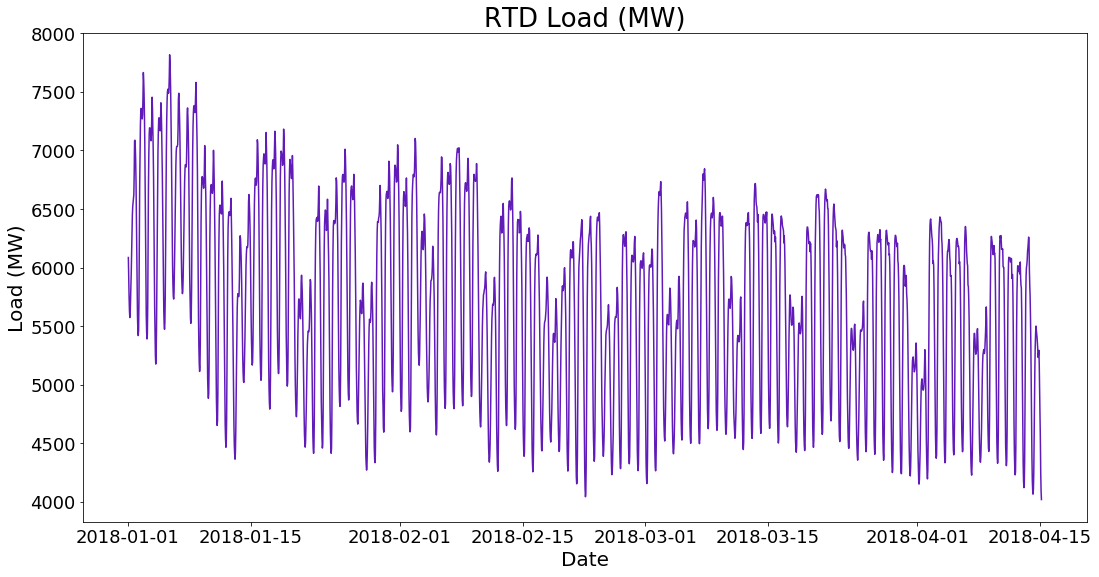

In [20]:
plot_series(load_weather_combined.head(2500), 
            ['RTD Actual Load'], 
            title = 'RTD Load (MW)',
            xlab = "Date",
            ylab = "Load (MW)")

### Cleaning Load Data

---
## Feature Engineering

### Simple date-time feature engineering

In [21]:
load_weather_combined['month']=pd.DatetimeIndex(load_weather_combined.index).month

In [22]:
#Monday =0, Sunday =6
load_weather_combined['weekday']=pd.DatetimeIndex(load_weather_combined.index).weekday

In [23]:
#https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime/53694615
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

In [24]:
load_weather_combined['season'] = load_weather_combined.index.map(season_of_date)

In [25]:
load_weather_combined.head(3)

Zone PTID  RTD Actual Load  maxtempC  mintempC  \
2018-01-01 01:00:00      61761      6085.233333        -7       -12   
2018-01-01 02:00:00      61761      5910.608333        -7       -12   
2018-01-01 03:00:00      61761      5749.016667        -7       -12   

                     totalSnow_cm  sunHour  uvIndex  moon_illumination  \
2018-01-01 01:00:00           0.0      8.7        2                 97   
2018-01-01 02:00:00           0.0      8.7        2                 97   
2018-01-01 03:00:00           0.0      8.7        2                 97   

                     moonrise   moonset  ... precipMM pressure  tempC  \
2018-01-01 01:00:00  05:34 PM  07:33 AM  ...      0.0     1028    -11   
2018-01-01 02:00:00  05:34 PM  07:33 AM  ...      0.0     1028    -11   
2018-01-01 03:00:00  05:34 PM  07:33 AM  ...      0.0     1028    -11   

                     visibility  winddirDegree  windspeedKmph  location  \
2018-01-01 01:00:00          10            324             27       nyc   
2018-01-01 02:00:00          10            323             27       nyc   
2018-01-01 03:00:00          10            322             27       nyc   

                     month  weekday  season  
2018-01-01 01:00:00      1        0  winter  
2018-01-01 02:00:00      1        0  winter  
2018-01-01 03:00:00      1        0  winter  

[3 rows x 29 columns]

## Univariate Time Series Model

In [26]:
df_univariate=load_weather_combined[["RTD Actual Load"]].copy()

In [27]:
df_univariate.head(3)

RTD Actual Load
2018-01-01 01:00:00      6085.233333
2018-01-01 02:00:00      5910.608333
2018-01-01 03:00:00      5749.016667

### ACF - univaritate

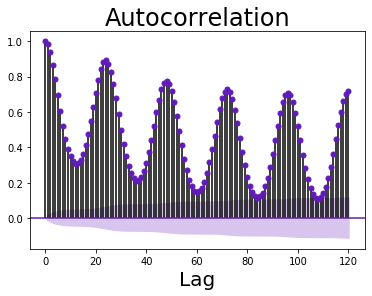

In [28]:
plot_acf(df_univariate["RTD Actual Load"], lags=120);
plt.title("Autocorrelation", fontsize= 24);
plt.xlabel("Lag", fontsize=20);

### PACF - univariate

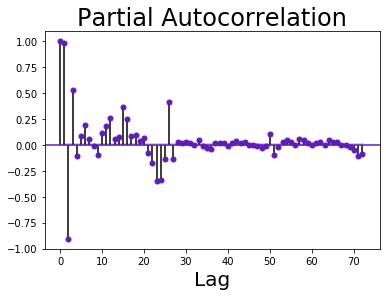

In [29]:
plot_pacf(df_univariate["RTD Actual Load"], lags=72);
plt.title("Partial Autocorrelation", fontsize= 24);
plt.xlabel("Lag", fontsize=20);

### Decomposition

<Figure size 1440x1440 with 0 Axes>

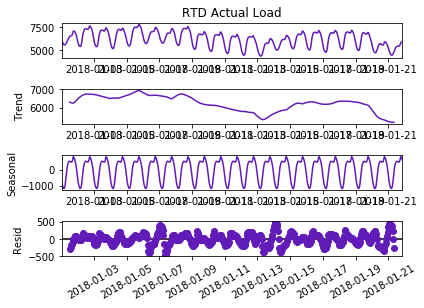

In [32]:
ax = plt.figure(figsize=(20,20));
decomp = seasonal_decompose(df_univariate["RTD Actual Load"].head(500));
decomp.plot();
ax.subplots_adjust(hspace=2.5, wspace=4);
plt.xticks(rotation=30);

### Stationary Check using Augmented Dickey Fuller Test - Univariate

In [39]:
def adfuller_test(series, autolag = 'BIC', signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag=autolag)
    output = {'test_statistic':round(r[0], 4), 
              'pvalue': round(r[1], 4), 
              'n_lags':round(r[2], 4), 
              'n_obs':r[3]}
    p_value = output['pvalue']

    def adjust(val, length= 6): 
        return str(val).ljust(length)

# Print Summary
    print(f'Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level = {signif}')
    print(f'Test Statistic = {output["test_statistic"]}')
    print(f'No. Lags Chosen = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

        if p_value <= signif:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")

        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")

In [41]:
 adfuller(df_univariate['RTD Actual Load'],autolag = 'AIC',regression='c')

(-7.344173955908851,
 1.0461226764860749e-10,
 43,
 17475,
 {'1%': -3.4307242638530675,
  '5%': -2.861705410152796,
  '10%': -2.5668580435332715},
 189505.11961769417)

In [42]:
# Train test Split
train, test = train_test_split(df_univariate,
                               test_size = 0.10,
                               shuffle=False)

In [43]:
print(train.shape)
print(test.shape)

(15767, 1)
(1752, 1)


### "GridSearching" for p and q - Univariate
Metric: AIC (Akaike information criterion)

IC works by evaluating the model's fit on the training data, and adding a penalty term for the complexity of the model (similar fundamentals to regularization). The desired result is to find the lowest possible AIC, which indicates the best balance of model fit with generalizability. This serves the eventual goal of maximizing fit on out-of-sample data.
Image for post
AIC equation, where L = likelihood and k = # of parameters

$$ AIC = -2ln(L) + 2k $$
where,  
$L$ = Likelihood  
$k$ = Number of parameters  

Parameters of ARIMA model:
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

In [44]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [45]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

> We performed the grid search on GoogleColab since our machine did not have necessary computation power for timely gridsearch. Please uncomment the last line in the following cell if you want to perform the grid search.

In [46]:
# evaluate parameters
p_values = [0, 1]
# d_values = range(0, 2)   # d = 0, Since our data is stationary
q_values = range(0, 2)
warnings.filterwarnings("ignore")
# evaluate_models(train["RTD Actual Load"], p_values, d_values, q_values)

In [47]:
train.head()

RTD Actual Load
2018-01-01 01:00:00      6085.233333
2018-01-01 02:00:00      5910.608333
2018-01-01 03:00:00      5749.016667
2018-01-01 04:00:00      5629.825000
2018-01-01 05:00:00      5572.533333

### Forecasting - Univariate

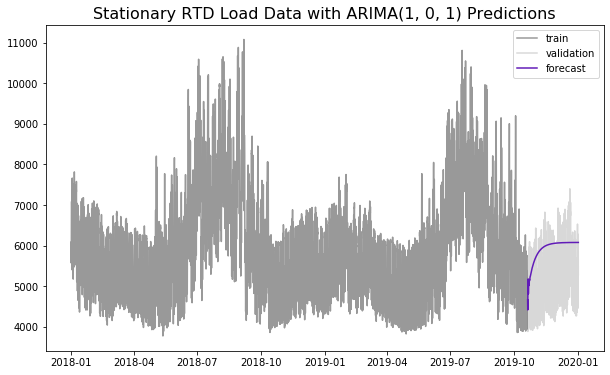

In [48]:
# Instantiate best model.
model = ARIMA(endog = train.astype(float).dropna(),  # y variable
                    order = (6, 0, 1)     # values for p, d, q
             ) 


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                      start = test.index[0],
                      end = test.index[-1]
                     )

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, pd.DataFrame(train), color = 'black', alpha=0.4, label='train')

# Plot testing data.
plt.plot(test.index, pd.DataFrame(test), color = 'grey', alpha = 0.3, label='validation')

# Plot predicted test values.
plt.plot(test.index, preds, color = '#611BB8', label='forecast')

plt.title(label = 'Stationary RTD Load Data with ARIMA(1, 0, 1) Predictions', fontsize=16)
plt.legend()
plt.show();

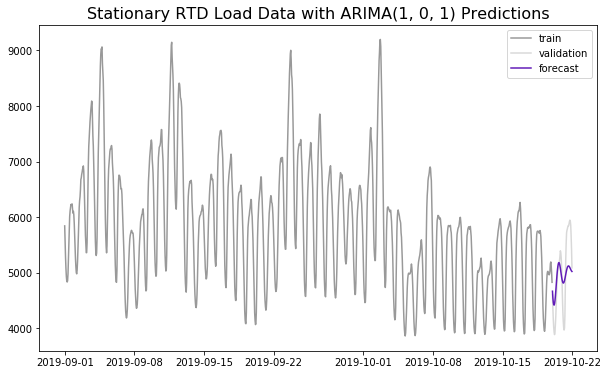

In [55]:
# Zoomed in version

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train['2019-09-01':'2019-10-19'].index, pd.DataFrame(train['2019-09-01':'2019-10-19']), color = 'black', alpha=0.4, label='train')

# Plot testing data.
plt.plot(test['2019-10-19':'2019-10-21'].index, pd.DataFrame(test['2019-10-19':'2019-10-21']), color = 'grey', alpha = 0.3, label='validation')

# Plot predicted test values.
plt.plot(test['2019-10-19':'2019-10-21'].index, preds[0:48], color = '#611BB8', label='forecast')

plt.title(label = 'Stationary RTD Load Data with ARIMA(1, 0, 1) Predictions', fontsize=16)
plt.legend()
plt.show();

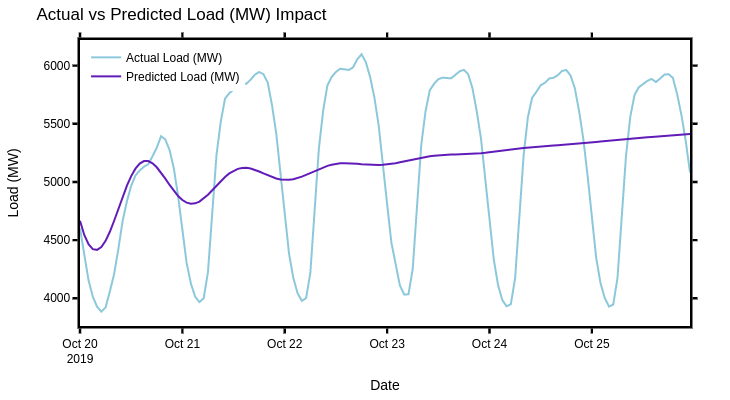

In [56]:
# plotly version
# load (ARIMA)
fig = go.Figure()

fig.add_trace(go.Scatter(x=test['2019-10-20':'2019-10-25'].index.tolist(), 
                         y=pd.DataFrame(test['2019-10-20':'2019-10-25'])["RTD Actual Load"].tolist(),
                         line=dict(color='#8CC8DB', width=2),  
                         name="Actual Load (MW)"))

fig.add_trace(go.Scatter(x=test['2019-10-20':'2019-10-25'].index.tolist(),
                         y=preds[0:len(test['2019-10-20':'2019-10-25'])].tolist(),
                         line=dict(color='#611BB8', width=2),
                         name="Predicted Load (MW)"))

fig.update_layout(
title="Actual vs Predicted Load (MW) Impact",
xaxis_title="Date", yaxis_title="Load (MW)", font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=1000,height=400,)
fig.update_layout(legend_orientation="v")

# choose the figure font
font_dict=dict(family='Arial',
               size=12,
               color='black'
               )

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

# general figure formatting
fig.update_layout(font=font_dict,  # font formatting
                  plot_bgcolor='white',  # background color
                  width=800,  # figure width
                  height=400,  # figure height
                  margin=dict(r=40,t=40,b=10)  # remove white space 
                  )

# x and y-axis formatting
fig.update_yaxes(title_text='Load (MW)',  # axis label
                 showline=True,  # add line at x=0
                 linecolor='black',  # line color
                 linewidth=2.4, # line size
                 ticks='outside',  # ticks outside axis
                 tickfont=font_dict, # tick label font
                 mirror='allticks',  # add ticks to top/right axes
                 tickwidth=2.4,  # tick width
                 tickcolor='black',  # tick color
                 )
fig.update_xaxes(title_text='Date',
                 showline=True,
                 showticklabels=True,
                 linecolor='black',
                 linewidth=2.4,
                 ticks='outside',
                 tickfont=font_dict,
                 mirror='allticks',
                 tickwidth=2.4,
                 tickcolor='black',
                 )

fig.show()

> From the zoomed in version of the forecast it is evident that our univariate ARIMA model was good at very short-term forecasting. The forecast converges toward the mean of the load data with time, as expected for time series modeling with ARIMA.

### Model Evaluation - Univariate

In [57]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        RTD Actual Load   No. Observations:                15767
Model:                     ARMA(6, 1)   Log Likelihood              -91773.210
Method:                       css-mle   S.D. of innovations             81.563
Date:                Fri, 14 Aug 2020   AIC                         183564.420
Time:                        23:35:36   BIC                         183633.411
Sample:                    01-01-2018   HQIC                        183587.254
                         - 10-19-2019                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6078.8123    170.587     35.635      0.000    5744.468    6413.157
ar.L1.RTD Actual Load     3.1951      0.005    691.744      0.000       3.186       3.204
ar.L2.RTD Actual Load    -3.9720      0.009   -426.420      0.000      -3.990      -3.954
ar.L3.RTD Actual Load     2.3870      0.009    272.989      0.000       2.370       2.404
ar.L4.RTD Actual Load    -0.6240      0.014    -43.232      0.000      -0.652      -0.596
ar.L5.RTD Actual Load    -0.0721      0.015     -4.786      0.000      -0.102      -0.043
ar.L6.RTD Actual Load     0.0857      0.006     14.420      0.000       0.074       0.097
ma.L1.RTD Actual Load    -0.9187      0.004   -245.742      0.000      -0.926      -0.911
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0044           -0.0000j            1.0044           -0.0000
AR.2            1.0065           -0.2861j            1.0464           -0.0441
AR.3            1.0065           +0.2861j            1.0464            0.0441
AR.4            0.8480           -1.4213j            1.6550           -0.1644
AR.5            0.8480           +1.4213j            1.6550            0.1644
AR.6           -3.8723           -0.0000j            3.8723           -0.5000
MA.1            1.0885           +0.0000j            1.0885            0.0000
-----------------------------------------------------------------------------
"""

<Figure size 864x864 with 0 Axes>

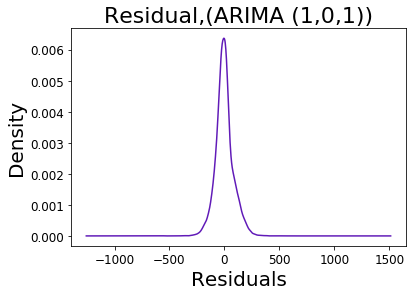

In [58]:
plt.figure(figsize=(12,12));
pd.DataFrame(arima.resid).plot(kind='kde');
plt.title("Residual,(ARIMA (1,0,1))", fontsize=22);
plt.xlabel("Residuals", fontsize=20);
plt.ylabel("Density", fontsize=20);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.legend().remove();

> One of the criteria for ARIMA model is heteroscedasticity. The normality depicted by the residual plot shown above confirms that our data set in fact showed heteroscedasticity characteristic with ARIMA model.

In [59]:
print(f"RMSE RTD Load prediction: {round(mean_squared_error(test, preds) ** 0.5, 4)} MW using ARIMA(6,0,1).")

RMSE RTD Load prediction: 888.8569 MW using ARIMA(6,0,1).


---

## Multivariate Time Series Model

* VAR (OLS), multivariate
* MAYBE SARIMA, multivariate

### Model Evaluation - Multivariate

In [61]:
df_multi = load_weather_combined.copy()

In [62]:
df_multi.drop(columns=['Zone PTID','sunHour','uvIndex','moon_illumination','moonrise','moonset',
                             'sunrise','sunset','visibility','location','FeelsLikeC','DewPointC','cloudcover',
                             'maxtempC','mintempC','HeatIndexC','month','winddirDegree','totalSnow_cm',
                              'precipMM','weekday','season','windspeedKmph'],
                             axis=1,inplace=True)

In [63]:
df_multi.head()

RTD Actual Load  WindChillC  WindGustKmph  humidity  \
2018-01-01 01:00:00      6085.233333         -20            31        70   
2018-01-01 02:00:00      5910.608333         -20            31        69   
2018-01-01 03:00:00      5749.016667         -20            32        69   
2018-01-01 04:00:00      5629.825000         -20            30        69   
2018-01-01 05:00:00      5572.533333         -21            29        69   

                     pressure  tempC  
2018-01-01 01:00:00      1028    -11  
2018-01-01 02:00:00      1028    -11  
2018-01-01 03:00:00      1028    -11  
2018-01-01 04:00:00      1029    -11  
2018-01-01 05:00:00      1029    -12

### EDA - Multivariate

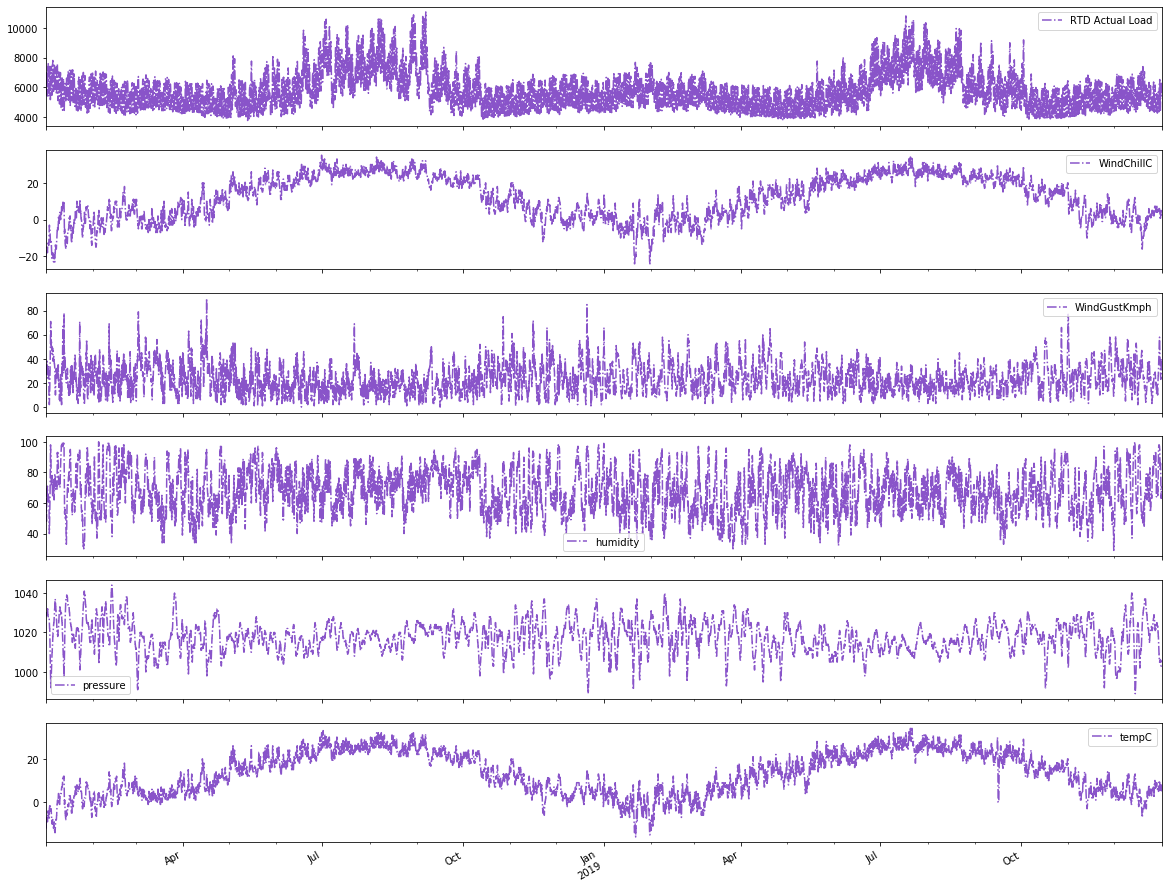

In [64]:
# plt.figure(figsize=(20,10))
df_multi.plot(subplots=True, 
                         layout=(7,1), 
                         figsize=(20,20), 
                         legend=True, 
                         color='#611BB8',
                         alpha = 0.75,
                         style='-.');

# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1);

### Decomposition WindGustKmph

<Figure size 1440x1440 with 0 Axes>

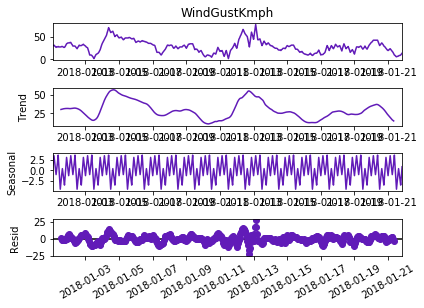

In [65]:
plt.figure(figsize=(20,20))
decomp = seasonal_decompose(df_multi['WindGustKmph'].head(500))
decomp.plot();
ax.subplots_adjust(hspace=2.5, wspace=4);
plt.xticks(rotation=30);

### Use Johansen Test to Check Stationarity of Model and Cointegration

#### Conditions that Johansen Test is Checking:

The eigenvalues computed using coint_johansen are between (-1,1). There are three possible outcomes when conducting coint_johansen:

1. The eigenvalues equal 0. In this case, the variables are not cointegrated.

2. The eigenvalues are less than 0. In this case, there appears to be a linear combination of the one of the vectors within the vector equations. This implies that the vectors are not linearly independent, and therefore we can conclude stationarity exists and must be corrected.

3. The eigenvalues are greater than 0 but less than 1. In this case, stationarity is not violated. Hence, variables are not cointegrated. 

In [66]:
df_multi.head()

RTD Actual Load  WindChillC  WindGustKmph  humidity  \
2018-01-01 01:00:00      6085.233333         -20            31        70   
2018-01-01 02:00:00      5910.608333         -20            31        69   
2018-01-01 03:00:00      5749.016667         -20            32        69   
2018-01-01 04:00:00      5629.825000         -20            30        69   
2018-01-01 05:00:00      5572.533333         -21            29        69   

                     pressure  tempC  
2018-01-01 01:00:00      1028    -11  
2018-01-01 02:00:00      1028    -11  
2018-01-01 03:00:00      1028    -11  
2018-01-01 04:00:00      1029    -11  
2018-01-01 05:00:00      1029    -12

In [67]:
pd.DataFrame(coint_johansen(df_multi, -1, 1).eig, columns=["eigenvalues"])

eigenvalues
0     0.197850
1     0.065932
2     0.049056
3     0.028341
4     0.004317
5     0.000004

> Since our variables have **0 < eigenvalues < 1** `cointegration`, `stationarity` and `linear dependence` are non issues. So we can proceed to create train and validation sets.

#### Train-Test Split

> Because this is time series data, we do not want to shuffle our train set, and we must also keep in mind that both sets need to maintain chronological order. Therefore, we split train on the first 95% of data and the remainder 5% of 2019 is kept as validation data.

In [68]:
#create train and validation set
train_multi, validation_multi= train_test_split(df_multi,
                               test_size = 0.05,
                               shuffle=False)

In [69]:
train_multi.shape,validation_multi.shape

((16643, 6), (876, 6))

### VAR model

#### Choosing VAR Lag Length Selection

https://faculty.washington.edu/ezivot/econ584/notes/varModels.pdf

On page 388, Chapter 11, of _Vector Autoregressive Models for Multivariate Time Series, written by authors Zivot, Eric, Wang, Jiahui_, the following on Lag Length Selection was considered during model fit:

The lag length for the $VAR(p)$ model may be determined using model
selection criteria. The general approach is to fit $VAR(p)$ models with orders $p = 0, \cdots, pmax $ and choose the value of $p$ which minimizes some model selection criteria. 

The three most common information criteria are:
* the Akaike (AIC), 
* Schwarz-Bayesian (BIC), and
* Hannan-Quinn (HQ).

However, the AIC criterion asymptotically overestimates the order with positive probability, whereas the BIC and HQ criteria estimate the order consistently under fairly general conditions if the true order $p$ is less than or equal to pmax. 

**Therefore, we chose (BIC) as our information criterion.**

So far, in our lectures, we have assumed that all variables of a multivariate system are all determined within the system. Hence, only using VAR(endog=train).

In other words, this assumption implies there is a _joint generation process_ of all the observable variables of interest.

In practice, the generation process required to accurately forecast dynamical systems may be affected by other observable variables, which are determined outside the system we are trying to predict. These variables are called _exogenous variables_. Whereas variables determined within the system are called _endogenous_.

Although deterministic variables can be included in the set of exogenous variables, often exogenous variables are stochastic in nature. For example, weather related variables such as rainfall or hours of sunshine are typically interpreted as stochastic exogenous variables.

Hence, $y_t$ contains the observable outputs of the system, that is, the observable variables that are determined by the system. In contrast, the $x_t$ variables may be regarded as observable input variables which are determined outside the system.

Our understanding of the impact Wind Gust has on Load Impact, coupled with the aforementioned reasoning, led us to conclude that `Load Impact` and `Wind Gust` should be defined as endogenous variables within our system. However, we also believed that additional weather conditions warranted consideration as stochastic exogenous variables, which could affect the generating process of our endogenous variables.

**Source:** _New Introduction to Multiple Time Series Analysis by Helmut Lütkepohl_


In [74]:
endog_df=train_multi[['RTD Actual Load','WindGustKmph']]
endog_df.head(3)

RTD Actual Load  WindGustKmph
2018-01-01 01:00:00      6085.233333            31
2018-01-01 02:00:00      5910.608333            31
2018-01-01 03:00:00      5749.016667            32

In [75]:
exog_df=train_multi.drop(columns=['RTD Actual Load','WindGustKmph'])
exog_df.head(3)

WindChillC  humidity  pressure  tempC
2018-01-01 01:00:00         -20        70      1028    -11
2018-01-01 02:00:00         -20        69      1028    -11
2018-01-01 03:00:00         -20        69      1028    -11

#### Augmented Dickey-Fuller Test - Multivariate

In [71]:
adfuller_test(df_multi['RTD Actual Load'], autolag='BIC')

Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -8.6457
No. Lags Chosen = 35
 Critical value 1%     = -3.431
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.862
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [72]:
adfuller_test(df_multi['WindGustKmph'], autolag='BIC')

Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -17.2078
No. Lags Chosen = 31
 Critical value 1%     = -3.431
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.862
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


#### Model and fit

In [76]:
from statsmodels.tsa.vector_ar.var_model import VAR

#instantiate model
model = VAR(endog=endog_df, exog=exog_df)

#fit model
res=model.fit(maxlags=6, ic='bic')

### Autocorrelation Plot - Multivariate

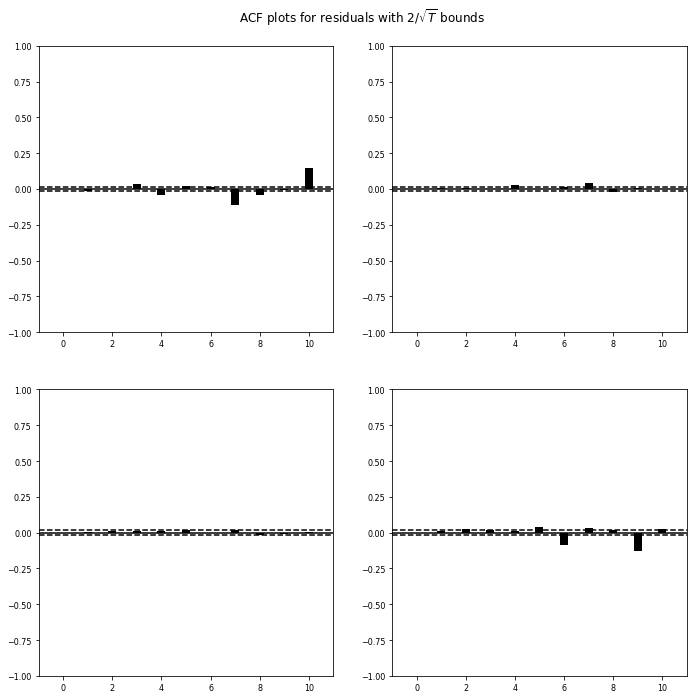

In [77]:
res.plot_acorr();

### Seasonality in the endogenous variables `Actual Load`, `Wind Gust Speed`

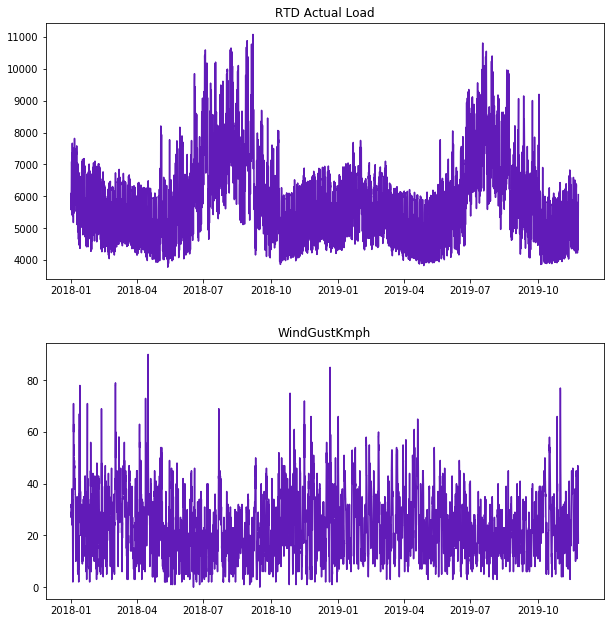

In [78]:
ax=res.plot();
ax.subplots_adjust(hspace=0.25,bottom=.1,top=.9)

#### Predictions on Validation Set

In [79]:
# res.y=endog_df.values where y is an attribute of VAR model 
prediction= res.forecast(endog_df.values, #forecast of endogenous training set
                         steps=16643, #steps are equal to length of test set to compare y_hat to y_actuals
                         exog_future=exog_df)#forecast of exogenous training set


#### Evaluation of VAR Model 

### RMSE

In [80]:
# Predictions
pred_load = prediction[:,0].tolist()
pred_windGust = prediction[:,1].tolist()

# Actuals
actual_load = validation_multi["RTD Actual Load"].tolist()
actual_windGust = validation_multi["WindGustKmph"].tolist()

In [81]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_load = rmse(np.array(pred_load[0:876]), np.array(actual_load))
print(f"RMSE RTD Load: {round(rmse_load,4)} MW.")

rmse_windGust = rmse(np.array(pred_windGust[0:876]), np.array(actual_windGust))
print(f"RMSE Wind Gust Actual Load: {round(rmse_windGust,4)} mph.")

RMSE RTD Load: 846.7209 MW.
RMSE Wind Gust Actual Load: 15.0602 mph.


In [82]:
# Creating a dataframe of actuals and predictions for load and windGust
# for residuals and plots
endog_actual_pred = [actual_load, pred_load, actual_windGust,pred_windGust]
endog_actual_pred_df = pd.DataFrame(endog_actual_pred).T
endog_actual_pred_df.columns = ["Actual Load", "Predicted Load", "Actual Wind Gust", "Predicted Wind Gust"]

endog_actual_pred_df["Residual Load"] = endog_actual_pred_df["Actual Load"] - endog_actual_pred_df["Predicted Load"]
endog_actual_pred_df["Residual Wind Gust"] = endog_actual_pred_df["Actual Wind Gust"] - endog_actual_pred_df["Predicted Wind Gust"]

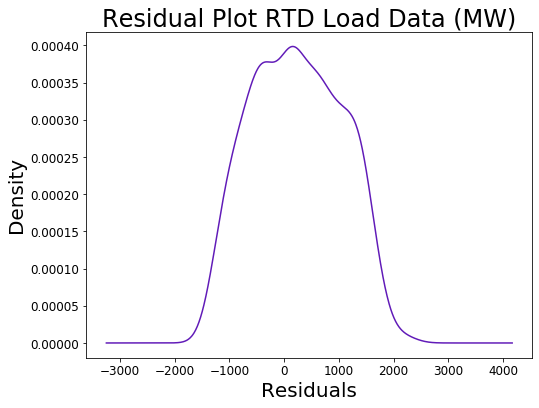

In [83]:
# Residual plot of Load 
plt.figure(figsize=(8,6))
endog_actual_pred_df["Residual Load"].plot(kind='kde');
plt.title("Residual Plot RTD Load Data (MW)", fontsize=24);
plt.xlabel("Residuals", fontsize=20);
plt.ylabel("Density", fontsize=20);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

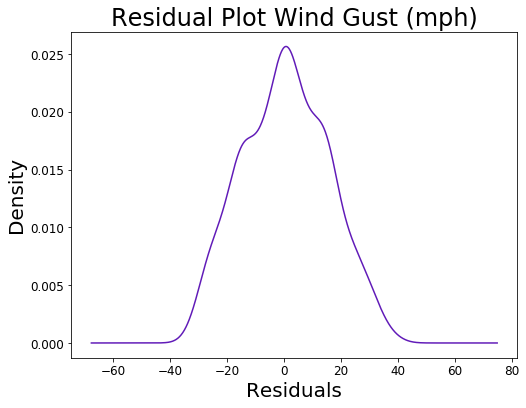

In [84]:
# Residual plot of Wind
plt.figure(figsize=(8,6))
endog_actual_pred_df["Residual Wind Gust"].plot(kind='kde');
plt.title("Residual Plot Wind Gust (mph)", fontsize=24);
plt.xlabel("Residuals", fontsize=20);
plt.ylabel("Density", fontsize=20);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

### Final Prediction

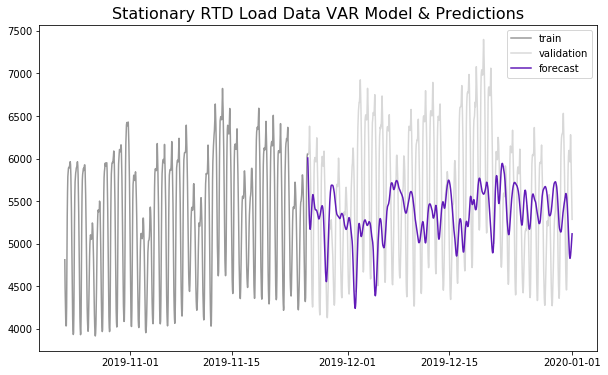

In [85]:
# Zoomed in version LOAD

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(endog_df['2019-10-23':'2019-11-25 11:00:00']['RTD Actual Load'].index, pd.DataFrame(endog_df['2019-10-23':'2019-11-25 11:00:00']['RTD Actual Load']), color = 'black', alpha=0.4, label='train')

# Plot testing data.
plt.plot(validation_multi['2019-11-25 12:00:00':'2019-12-31']['RTD Actual Load'].index, pd.DataFrame(validation_multi['2019-11-25 12:00:00':'2019-12-31']['RTD Actual Load']), color = 'grey', alpha = 0.3, label='validation')

# Plot predicted test values.
plt.plot(validation_multi['2019-11-25':'2019-12-31'].index, pred_load[0:876], color = '#611BB8', label='forecast')

plt.title(label = 'Stationary RTD Load Data VAR Model & Predictions', fontsize=16)
plt.legend()
plt.show();


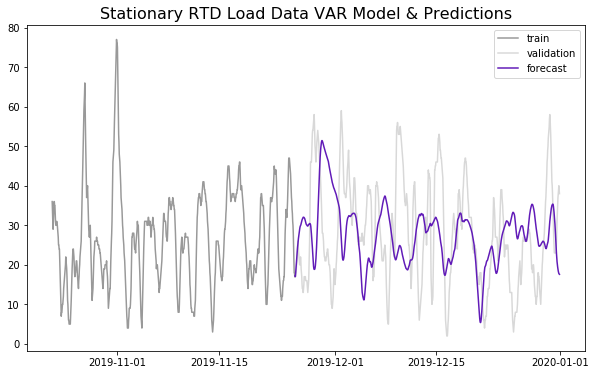

In [86]:
# Zoomed in version WIND

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(endog_df['2019-10-23':'2019-11-25 11:00:00']['WindGustKmph'].index, pd.DataFrame(endog_df['2019-10-23':'2019-11-25 11:00:00']['WindGustKmph']), color = 'black', alpha=0.4, label='train')

# Plot testing data.
plt.plot(validation_multi['2019-11-25 12:00:00':'2019-12-31']['WindGustKmph'].index, pd.DataFrame(validation_multi['2019-11-25 12:00:00':'2019-12-31']['WindGustKmph']), color = 'grey', alpha = 0.3, label='validation')

# Plot predicted test values.
plt.plot(validation_multi['2019-11-25':'2019-12-31'].index, pred_windGust[0:876], color = '#611BB8', label='forecast')

plt.title(label = 'Stationary RTD Load Data VAR Model & Predictions', fontsize=16)
plt.legend()
plt.show();

### VAR model summary

In [87]:
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Aug, 2020
Time:                     23:50:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.77404
Nobs:                     16637.0    HQIC:                   9.76348
Log likelihood:          -128354.    FPE:                    17296.6
AIC:                      9.75827    Det(Omega_mle):         17261.3
--------------------------------------------------------------------
Results for equation RTD Actual Load
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                    285.881329       102.566432            2.787           0.005
WindChillC                -4.565843         0.437371          -10.439           0.000
humidity                  -0.1

### Conclusion

#### compare univariate(ARIMA) model vs  multivariate (VAR) model




# TODO

    
1. [DONE] change train test split for univariate from 50/50 to a different split so that forecast on Stationary RTD Load Data does not trend to the mean as quickly
2. [DONE] RMSE for Multivariate
3. [ ] Forecast plot for multivariate
4. Bar plot comparing RMSE values for ARIMA and VAR model


# If we have time
* visualization of number of customers affected
* try log windgust to correct for non-normal dist